# Motorcycle heteroscedastic noise example

In [9]:
from typing import Tuple, Optional
from pathlib import Path

import numpy as np
import tensorflow as tf
import gpflow

from gpflow.config import default_float
from gpflow.utilities import print_summary
from gpflow.utilities import set_trainable

from gpflow.likelihoods import Likelihood

import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions

from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt

## Specify the heteroscedastic noise GP model

In [2]:
# Pretty much based on this example given on Stack Overflow (with the change of having f and g independent):
# https://stackoverflow.com/questions/57597349/likelihoods-combining-multiple-latent-gps-in-gpflow

class MultiLatentLikelihood(Likelihood):
    def __init__(self, num_latent=1, **kwargs):
        super().__init__(**kwargs)
        self.num_latent = num_latent

    def _transform(self, F):
        return [F[:, i] for i in range(self.num_latent)]

    def predict_mean_and_var(self, Fmu, Fvar):
        return super().predict_mean_and_var(self._transform(Fmu), self._transform(Fvar))

    def predict_density(self, Fmu, Fvar, Y):
        return super().predict_density(self._transform(Fmu), self._transform(Fvar), Y)

    def variational_expectations(self, Fmu, Fvar, Y):
        return super().variational_expectations(self._transform(Fmu), self._transform(Fvar), Y)

class HeteroscedasticGaussian(MultiLatentLikelihood):
    r"""
    When using this class, num_latent must be 2.
    It does not support multi-output (num_output will be 1)
    """
    def __init__(self, transform=tf.nn.softplus, **kwargs):
        super().__init__(num_latent=2, **kwargs)
        self.transform = transform

    def Y_given_F(self, F, G):
        mu = tf.squeeze(F)
        sigma = self.transform(tf.squeeze(G))
        Y_given_F = tfd.Normal(mu, sigma)
        return Y_given_F

    def log_prob(self, F, G, Y):
        return self.Y_given_F(F, G).log_prob(Y) #was log_prob

    def conditional_mean(self, F, G):
        return self.Y_given_F(F, G).mean()

    def conditional_variance(self, F, G):
        return self.Y_given_F(F, G).variance()

In [4]:
# Load the data
D = np.loadtxt('mcycle.csv',delimiter=',')
X = D[:,1:2]
Y = D[:,2:]
N = X.shape[0]

# Store original data
x0 = X.copy()
y0 = Y.copy()

# Force into Nx1 format
#X = x[:, None].reshape(N,1)
#y = y[:, None].reshape(N,1)

# standardize
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(Y)
X = X_scaler.transform(X)
Y = y_scaler.transform(Y)

In [6]:
# Kernel
kern_list = [gpflow.kernels.Matern32(variance=3., lengthscale=1.), 
             gpflow.kernels.Matern32(variance=3., lengthscale=1.)]
kernel = gpflow.kernels.SeparateIndependent(kern_list)

# Inducing points (we hack this through SVGP, because the SpearateIndependent support in plain
# VGP was broken). We simply put an inducing point at every data point.
Xu = X.copy()
inducing_variables = gpflow.inducing_variables.mo_inducing_variables.\
    SharedIndependentInducingVariables(gpflow.inducing_variables.InducingPoints(Xu))

# The model
model = gpflow.models.SVGP(kernel=kernel, likelihood=HeteroscedasticGaussian(), 
                           inducing_variable=inducing_variables, num_latent=2)

# Set trainable (everything except the 'inducing' points, because we want the full model).
set_trainable(model, True)
set_trainable(model.inducing_variable.inducing_variable_shared.Z,False)

# Print model
gpflow.utilities.print_summary(model, fmt='notebook')

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,3.0
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.0
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(133, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(133, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 133, 133)",float64,"[[[1., 0., 0...."


<tf.Tensor: shape=(), dtype=float64, numpy=108571.50857241324>

In [7]:
# Optimize parameters
o = gpflow.optimizers.Scipy()
@tf.function(autograph=False)
def objective():
    return -model.elbo((X,Y))
o.minimize(objective, variables=model.trainable_variables)

      fun: 80.46667294280795
 hess_inv: <18092x18092 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00080509, -0.006521  ,  0.00014671, ..., -0.00033201,
        0.00015528,  0.00046596])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1004
      nit: 919
   status: 0
  success: True
        x: array([5.73225587e-02, 5.52412280e-01, 6.77364168e-01, ...,
       9.02532612e-06, 3.26632908e-05, 3.19399738e-05])

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.007022868949929
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.7222191381301071
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.5810233780483713
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.0881180066881915
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(133, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(133, 2)",float64,"[[5.17323547e-01, -1.80731257e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 133, 133)",float64,"[[[2.26214836e-02, 0.00000000e+00, 0.00000000e+00..."


<tf.Tensor: shape=(), dtype=float64, numpy=0.14678245486207492>

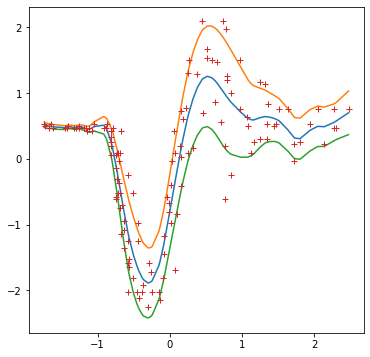

In [10]:
# Set up plotting
def plot(m, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    mu, var = m.predict_y(X)
    ax.plot(X,mu)
    ax.plot(X,mu+tf.sqrt(var))
    ax.plot(X,mu-tf.sqrt(var))
    ax.plot(X,Y,'+')

# Plot model    
plot(model)

# Print model
gpflow.utilities.print_summary(model, fmt='notebook')

# NLPD on training data
-tf.reduce_mean(model.predict_log_density((X,Y)))

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9428980561335885
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6837062276916549
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.36413644406421
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.059669268537749
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.34421687e-01, -1.81901561e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[2.51200513e-02, 0.00000000e+00, 0.00000000e+00..."


0.3160674772183717


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9348121295019971
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6623695700716785
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.809663489042786
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.2520209391380246
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.38087974e-01, -1.84702057e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[1.99380849e-02, 0.00000000e+00, 0.00000000e+00..."


0.13410541704734452


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9314802930423939
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6679818359224393
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.781967480458717
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.1197166311994438
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.38275121e-01, -1.75523712e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[-2.37940067e-02, 0.00000000e+00, 0.00000000e+00..."


0.8928924606558838


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9309595700438261
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6706007932694891
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.7252536852161593
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.3375325699004068
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.38630411e-01, -1.78283532e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[2.34351316e-02, 0.00000000e+00, 0.00000000e+00..."


0.974411215734819


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9653911281148256
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6810984450598295
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.593983876606837
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.097648732945586
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.28589941e-01, -1.79169495e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[2.36786793e-02, 0.00000000e+00, 0.00000000e+00..."


0.263614186680174


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9947171947777066
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6561430442463905
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,4.142571690992516
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.2825544100321817
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.24059645e-01, -1.86112283e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[1.65932154e-02, 0.00000000e+00, 0.00000000e+00..."


0.6166193625568634


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9662848183613777
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6876325611256521
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.4874907491941394
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.094160690555136
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.28313840e-01, -1.82196832e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[2.35460077e-02, 0.00000000e+00, 0.00000000e+00..."


0.32566486656206534


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.985516632688072
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.7225287853300474
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.602744403686405
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.2503957950503997
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.23232466e-01, -1.82390925e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[-2.21900394e-02, 0.00000000e+00, 0.00000000e+00..."


0.5777337614350275


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9828228276504283
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6829091043351767
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,2.936754322342784
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,0.8840455548929986
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.68001361...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[4.95116438e-01, -1.84106632e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[3.17867806e-02, 0.00000000e+00, 0.00000000e+00..."


0.34961202331949204


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.9521883679855928
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.6940158227733912
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,6.3763567518219615
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.694682866792261
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(117, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(117, 2)",float64,"[[5.40171722e-01, -1.77236037e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 117, 117)",float64,"[[[9.13412542e-03, 0.00000000e+00, 0.00000000e+00..."


-0.013580664062776932


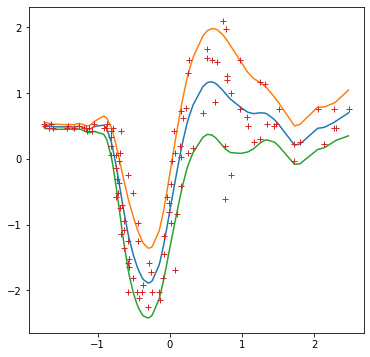

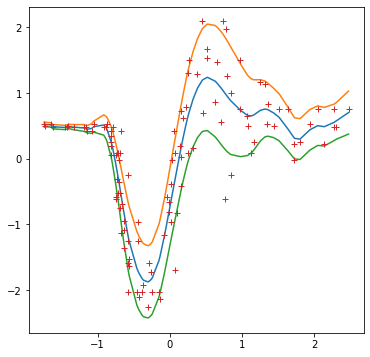

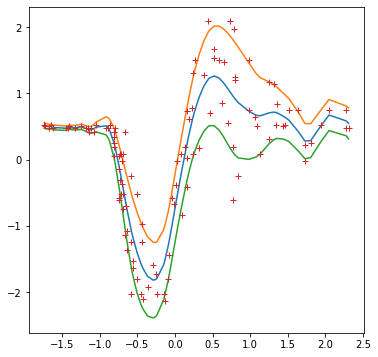

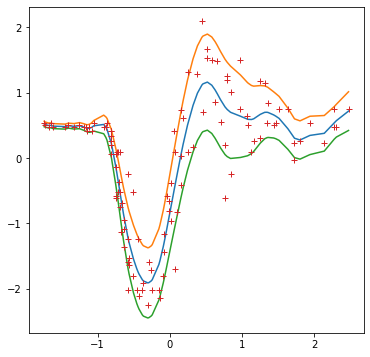

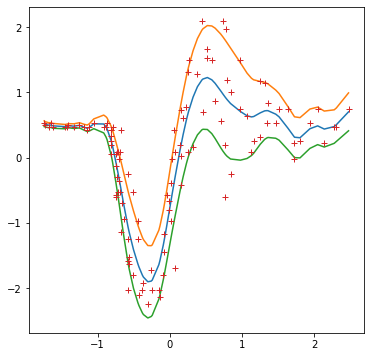

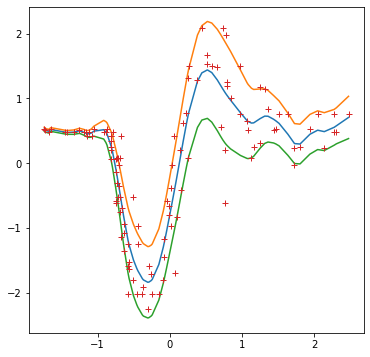

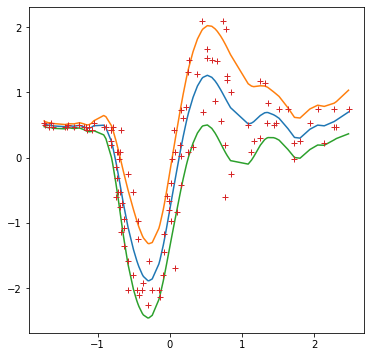

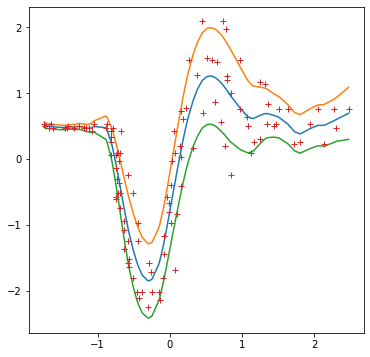

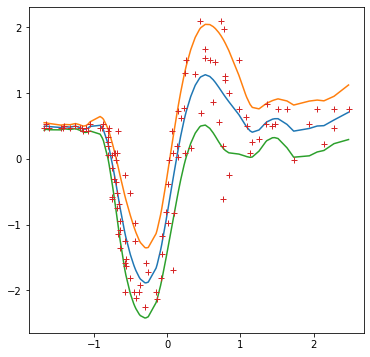

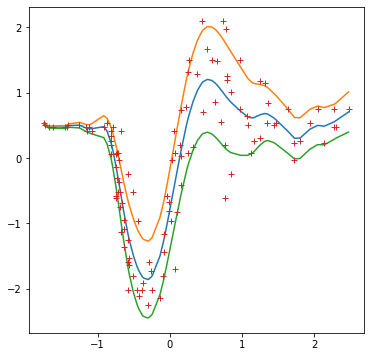

In [12]:
# Load data
D = np.loadtxt('mcycle.csv',delimiter=',')
X = D[:,1:2]
Y = D[:,2:]
N = X.shape[0]

# Standardize
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(Y)
Xall = X_scaler.transform(X)
Yall = y_scaler.transform(Y)

# Load cross-validation indices
cvind = np.loadtxt('cvind.csv').astype(int)

# 10-fold cross-validation setup
nt = np.floor(cvind.shape[0]/10).astype(int)
cvind = np.reshape(cvind[:10*nt],(10,nt))

# The model
def run_fold(X,Y,XT,YT):

    # Kernel
    kern_list = [gpflow.kernels.Matern32(variance=3., lengthscale=1.), 
                 gpflow.kernels.Matern32(variance=3., lengthscale=1.)]
    kernel = gpflow.kernels.SeparateIndependent(kern_list)

    # Inducing points (we hack this through SVGP, because the SpearateIndependent support in plain
    # VGP was broken). We simply put an inducing point at every data point.
    Xu = X.copy()
    inducing_variables = gpflow.inducing_variables.mo_inducing_variables.\
        SharedIndependentInducingVariables(gpflow.inducing_variables.InducingPoints(Xu))

    # The model
    model = gpflow.models.SVGP(kernel=kernel, likelihood=HeteroscedasticGaussian(), 
                               inducing_variable=inducing_variables, num_latent=2)

    # Set trainable (everything except the 'inducing' points, because we want the full model).
    set_trainable(model, True)
    set_trainable(model.inducing_variable.inducing_variable_shared.Z,False)

    # Optimize parameters
    o = gpflow.optimizers.Scipy()
    @tf.function(autograph=False)
    def objective():
        return -model.elbo((X,Y))
    o.minimize(objective, variables=model.trainable_variables)
    
    # Plot model    
    plot(model)

    # Print model
    gpflow.utilities.print_summary(model, fmt='notebook')
    
    # Return NLPD
    return -tf.reduce_mean(model.predict_log_density((XT,YT))).numpy()

# Array of NLPDs
nlpd = []

# Run for each fold
for fold in np.arange(10):
    
    # Get training and test indices
    test = cvind[fold,:]
    train = np.setdiff1d(cvind,test)

    # Set training and test data
    X = Xall[train,:]
    Y = Yall[train,:]
    XT = Xall[test,:]
    YT = Yall[test,:]
    
    #. Run results
    res = run_fold(X,Y,XT,YT)
    nlpd.append(res)
    print(res)

In [13]:
np.mean(nlpd)

0.4437140107147264

In [14]:
np.std(nlpd) # 0.444 \pm 0.30

0.3012896657764487

In [254]:
# OLD STUFF

In [131]:
# Load data
D = np.loadtxt('mcycle.csv',delimiter=',')
X = D[:,1:2]
Y = D[:,2:]

# The covariance function
kernel = gpflow.kernels.Matern32()

# The likelihood
likelihood = HeteroscedasticGaussian()

# Set up the model
model = gpflow.models.VGP(
    (X,Y),
    kernel=kernel, 
    likelihood=likelihood, 
    num_latent=2
)

In [60]:
# Optimize hyperparameters
o = gpflow.optimizers.Scipy()
@tf.function(autograph=False)
def objective():
    return -model.log_marginal_likelihood()
o.minimize(objective, variables=model.trainable_variables)

gpflow.utilities.print_summary(model, fmt='notebook')


model.log_likelihood()

name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.variance,Parameter,Softplus,,True,(),float64,788.3605570568918
VGP.kernel.lengthscale,Parameter,Softplus,,True,(),float64,8.646283053447995
VGP.q_mu,Parameter,,,True,"(133, 2)",float64,"[[-1.36022980e-02, 3.95944903e-02..."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 133, 133)",float64,"[[[2.82052197e-02, 0.00000000e+00, 0.00000000e+00..."


<tf.Tensor: shape=(), dtype=float64, numpy=-612.7966064303273>

<tf.Tensor: shape=(), dtype=float64, numpy=4.049224321428872>

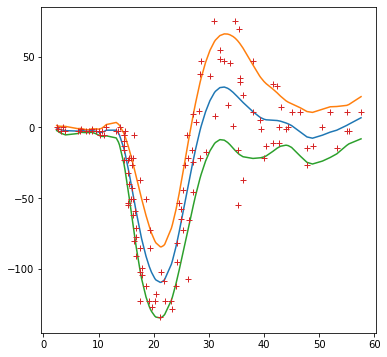

In [61]:
# Set up plotting
def plot(m, ax=None):
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(6, 6))
    
    mu, var = m.predict_y(X)
    ax.plot(X,mu)
    ax.plot(X,mu+tf.sqrt(var))
    ax.plot(X,mu-tf.sqrt(var))
    ax.plot(X,Y,'+')

# Plot model    
plot(model)

# Print model
-tf.reduce_mean(model.predict_log_density((X,Y)))

#model.log_marginal_likelihood()

In [31]:
class MultiOutputLikelihood(Likelihood):
    def __init__(self, num_latent=1, **kwargs):
        super().__init__(**kwargs)
        self.num_latent = num_latent

    def _transform(self, F):
        return [F[:,:, i] for i in range(self.num_latent)]

    def predict_mean_and_var(self, Fmu, Fvar):
        return super().predict_mean_and_var(self._transform(Fmu), self._transform(Fvar))

    def predict_density(self, Fmu, Fvar, Y):
        return super().predict_density(self._transform(Fmu), self._transform(Fvar), Y)

    def variational_expectations(self, Fmu, Fvar, Y):
        return super().variational_expectations(self._transform(Fmu), self._transform(Fvar), Y)

class HeteroscedasticGaussian(MultiOutputLikelihood):
    r"""
    When using this class, num_latent must be 2.
    It does not support multi-output (num_output will be 1)
    """
    def __init__(self, transform=tf.nn.softplus, **kwargs):
        super().__init__(num_latent=2, **kwargs)
        self.transform = transform

    def Y_given_F(self, F, G):
        mu = tf.squeeze(F)
        sigma = self.transform(tf.squeeze(G))
        Y_given_F = tfd.Normal(mu, sigma)
        return Y_given_F

    def log_prob(self, F, G, Y):
        return self.Y_given_F(F, G).log_prob(Y)

    def conditional_mean(self, F, G):
        return self.Y_given_F(F, G).mean()

    def conditional_variance(self, F, G):
        return self.Y_given_F(F, G).variance()



In [6]:
# The covariance function
kernel0 = gpflow.kernels.Matern32()
kernel1 = gpflow.kernels.Matern32()
kernel = gpflow.kernels.SeparateIndependent(kernels=[kernel0,kernel1])

# The likelihood
likelihood = HeteroscedasticGaussian()

# Set up the model
model = gpflow.models.VGP(
    (X,np.hstack((Y,Y))),
    kernel=kernel, 
    likelihood=likelihood, 
    num_latent=2
)

gpflow.utilities.print_summary(model, fmt='notebook')



name,class,transform,prior,trainable,shape,dtype,value
VGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.0
VGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.0
VGP.q_mu,Parameter,,,True,"(133, 2)",float64,"[[0., 0...."
VGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 133, 133)",float64,"[[[1., 0., 0...."


In [7]:
# Optimize hyperparameters
o = gpflow.optimizers.Scipy()
@tf.function(autograph=False)
def objective():
    return -model.log_marginal_likelihood()
o.minimize(objective, variables=model.trainable_variables)



ValueError: in converted code:

    /Users/asolin/Documents/unorganized/2020-ICML-active-vi/GPflow/gpflow/optimizers/scipy.py:76 _tf_eval  *
        loss, grads = _compute_loss_and_gradients(closure, variables)
    /Users/asolin/Documents/unorganized/2020-ICML-active-vi/GPflow/gpflow/optimizers/scipy.py:127 _compute_loss_and_gradients  *
        loss = loss_cb()
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/def_function.py:568 __call__
        result = self._call(*args, **kwds)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/def_function.py:615 _call
        self._initialize(args, kwds, add_initializers_to=initializers)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/def_function.py:497 _initialize
        *args, **kwds))
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/function.py:2389 _get_concrete_function_internal_garbage_collected
        graph_function, _, _ = self._maybe_define_function(args, kwargs)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/function.py:2703 _maybe_define_function
        graph_function = self._create_graph_function(args, kwargs)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/function.py:2593 _create_graph_function
        capture_by_value=self._capture_by_value),
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/framework/func_graph.py:978 func_graph_from_py_func
        func_outputs = python_func(*func_args, **func_kwargs)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/eager/def_function.py:439 wrapped_fn
        return weak_wrapped_fn().__wrapped__(*args, **kwds)
    <ipython-input-7-a64005a07bdf>:5 objective
        return -model.log_marginal_likelihood()
    /Users/asolin/Documents/unorganized/2020-ICML-active-vi/GPflow/gpflow/models/model.py:45 log_marginal_likelihood
        return self.log_likelihood(*args, **kwargs) + self.log_prior()
    /Users/asolin/Documents/unorganized/2020-ICML-active-vi/GPflow/gpflow/models/vgp.py:93 log_likelihood
        K = self.kernel(x_data) + tf.eye(self.num_data, dtype=default_float()) * default_jitter()
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/math_ops.py:902 binary_op_wrapper
        return func(x, y, name=name)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/math_ops.py:1194 _add_dispatch
        return gen_math_ops.add_v2(x, y, name=name)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/ops/gen_math_ops.py:483 add_v2
        "AddV2", x=x, y=y, name=name)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/framework/op_def_library.py:742 _apply_op_helper
        attrs=attr_protos, op_def=op_def)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/framework/func_graph.py:595 _create_op_internal
        compute_device)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/framework/ops.py:3322 _create_op_internal
        op_def=op_def)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/framework/ops.py:1786 __init__
        control_input_ops)
    /Users/asolin/Library/Python/3.7/lib/python/site-packages/tensorflow_core/python/framework/ops.py:1622 _create_c_op
        raise ValueError(str(e))

    ValueError: Dimensions must be equal, but are 2 and 133 for 'add_2' (op: 'AddV2') with input shapes: [133,2,2], [133,133].


In [8]:
K = model.kernel.K(X,X)
model.log_marginal_likelihood()

InvalidArgumentError: Incompatible shapes: [133,2,2] vs. [133,133] [Op:AddV2] name: add/

In [28]:
model.kernel

ValueError: Ambiguous inputs: `diagonal` and `y` are not compatible.

In [37]:
# Smoke test
X = tf.random.uniform([5, 3])
Y = tf.random.uniform([5, 2])
kern_list = [gpflow.kernels.Matern52(), gpflow.kernels.Matern52()]
kernel = gpflow.kernels.SeparateIndependent(kern_list)
#model = gpflow.models.GPR(kernel=kernel, data=(X, Y))

likelihood = gpflow.likelihoods.Gaussian()

model = gpflow.models.VGP(
    (X,Y),
    kernel=kernel, 
    likelihood=likelihood, 
    num_latent=2
)
model.predict_f(X)
model.log_likelihood()

InvalidArgumentError: cannot compute AddV2 as input #1(zero-based) was expected to be a double tensor but is a float tensor [Op:AddV2] name: add/

In [9]:
kernel0 = gpflow.kernels.Matern32()
kernel1 = gpflow.kernels.Matern32()
kernel = gpflow.kernels.SeparateIndependent(kernels=[kernel0,kernel1])

kernel.K(X).numpy().shape

(133, 2, 133, 2)

In [242]:
from sklearn.preprocessing import StandardScaler

D = np.loadtxt('mcycle.csv',delimiter=',')
x = D[:,1:2]
y = D[:,2:]
N = x.shape[0]

# Store original data
x0 = x.copy()
y0 = y.copy()

# force into Nx1 format
X = x[:, None].reshape(N,1)
y = y[:, None].reshape(N,1)

# standardize
X_scaler = StandardScaler().fit(X)
y_scaler = StandardScaler().fit(y)
X = X_scaler.transform(X)
Y = y_scaler.transform(y)

In [251]:
import gpflow.inducing_variables.mo_inducing_variables as mf
from gpflow.inducing_variables import InducingPoints

# Load data
#D = np.loadtxt('mcycle.csv',delimiter=',')
#X = D[:,1:2]
#Y = D[:,2:]

# Kernel
kern_list = [gpflow.kernels.Matern32(variance=43., lengthscale=4.5), 
             gpflow.kernels.Matern32(variance=2., lengthscale=10.)]
kern_list = [gpflow.kernels.Matern32(variance=1500., lengthscale=9.), 
             gpflow.kernels.Matern32(variance=3000., lengthscale=50.)]
kern_list = [gpflow.kernels.Matern32(variance=3., lengthscale=1.), 
             gpflow.kernels.Matern32(variance=3., lengthscale=1.)]

kernel = gpflow.kernels.SeparateIndependent(kern_list)

# Inducing points
Xu = X.copy()
#Xu = np.linspace(np.min(X),np.max(X),32).reshape(32,1)
inducing_variables = gpflow.inducing_variables.mo_inducing_variables.\
    SharedIndependentInducingVariables(InducingPoints(Xu))

# The model
model = gpflow.models.SVGP(kernel=kernel, likelihood=HeteroscedasticGaussian(), 
                           inducing_variable=inducing_variables, num_latent=2)

# Set trainable
set_trainable(model, True)
set_trainable(model.inducing_variable.inducing_variable_shared.Z,False)

# Print model
gpflow.utilities.print_summary(model, fmt='notebook')

-model.log_marginal_likelihood((X,Y))




name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,3.0
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,1.0
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.0
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.0
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(133, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(133, 2)",float64,"[[0., 0...."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 133, 133)",float64,"[[[1., 0., 0...."


<tf.Tensor: shape=(), dtype=float64, numpy=108571.50857241324>

In [246]:
set_trainable(model, True)
set_trainable(model.inducing_variable.inducing_variable_shared.Z,False)
#model.q_mu.trainable = True
#model.q_sqrt.trainable = True

optimizer = tf.optimizers.Adam(learning_rate=0.1)
maxit = 1000
for i in range(maxit):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        obj = -model.elbo((X, Y))
        grads = tape.gradient(obj, model.trainable_variables)

    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    if i % 100 == 0:
        print('Iteration %2d: elbo=%2.5f' %(i, obj.numpy()))

gpflow.utilities.print_summary(model, fmt='notebook')



Iteration  0: elbo=84.87516
Iteration 100: elbo=1488.99158
Iteration 200: elbo=1462.07826
Iteration 300: elbo=1428.97075
Iteration 400: elbo=1391.62008
Iteration 500: elbo=1351.59203
Iteration 600: elbo=1310.07194
Iteration 700: elbo=1267.97334
Iteration 800: elbo=1225.99712
Iteration 900: elbo=1184.67246


name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,0.4621558776396343
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.3756333092799491
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,1.763084525600286
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,0.5407030202594654
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(32, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(32, 2)",float64,"[[0.84147039, -0.69743287..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 32, 32)",float64,"[[[-0.27468385, 0., 0...."


In [247]:
-tf.reduce_mean(model.predict_log_density((X,Y)))


<tf.Tensor: shape=(), dtype=float64, numpy=2.1730046820652142>

name,class,transform,prior,trainable,shape,dtype,value
SVGP.kernel.kernels[0].variance,Parameter,Softplus,,True,(),float64,1.007022868949929
SVGP.kernel.kernels[0].lengthscale,Parameter,Softplus,,True,(),float64,0.7222191381301071
SVGP.kernel.kernels[1].variance,Parameter,Softplus,,True,(),float64,3.5810233780483713
SVGP.kernel.kernels[1].lengthscale,Parameter,Softplus,,True,(),float64,1.0881180066881915
SVGP.inducing_variable.inducing_variable_shared.Z,Parameter,,,False,"(133, 1)",float64,[[-1.74116353...
SVGP.q_mu,Parameter,,,True,"(133, 2)",float64,"[[5.17323547e-01, -1.80731257e+00..."
SVGP.q_sqrt,Parameter,FillTriangular,,True,"(2, 133, 133)",float64,"[[[2.26214836e-02, 0.00000000e+00, 0.00000000e+00..."


<tf.Tensor: shape=(), dtype=float64, numpy=0.14678245486207492>

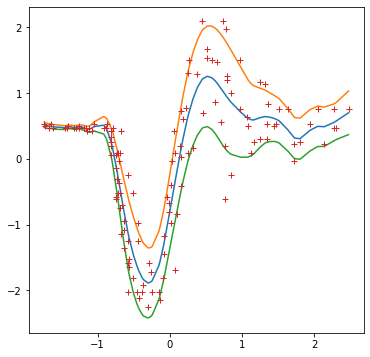

In [253]:
# Plot model    
plot(model)

gpflow.utilities.print_summary(model, fmt='notebook')

# Print model
-tf.reduce_mean(model.predict_log_density((X,Y)))

In [252]:
# Optimize hyperparameters
o = gpflow.optimizers.Scipy()
@tf.function(autograph=False)
def objective():
    return -model.elbo((X,Y))
o.minimize(objective, variables=model.trainable_variables)

      fun: 80.46667294280795
 hess_inv: <18092x18092 LbfgsInvHessProduct with dtype=float64>
      jac: array([-0.00080509, -0.006521  ,  0.00014671, ..., -0.00033201,
        0.00015528,  0.00046596])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 1004
      nit: 919
   status: 0
  success: True
        x: array([5.73225587e-02, 5.52412280e-01, 6.77364168e-01, ...,
       9.02532612e-06, 3.26632908e-05, 3.19399738e-05])